## End-to-end execution of the Syngenta Crop Disease Classification pipeline: Data preparation, deep learning model training, and comprehensive evaluation.

In [1]:
# ============================================================================
# 1. ENVIRONMENT SETUP & IMPORTS
# ============================================================================

import sys
from pathlib import Path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Force disable all GPUs
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))  # Should print []
print("CPUs:", tf.config.list_physical_devices('CPU'))


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# Add project root to sys.path to import src modules
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


In [4]:
from src import config
from src.data_utils import (DataPipeline, load_class_indices, preprocess_image)
from src.train import train_model_pipeline, plot_training_history, save_training_history
from src.evaluate import evaluate_model_performance, plot_confusion_matrix, \
                         visualize_sample_predictions, visualize_gradcam_for_samples

In [5]:
# Set random seeds for reproducibility
np.random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)
random.seed(config.RANDOM_SEED)


In [6]:
# GPU Configuration (FIXED)
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    #  FIX: Loop through each device
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"✓ GPU Available: {len(physical_devices)} device(s)")
    print(f"  Devices: {physical_devices}")
else:
    print("  WARNING: Running on CPU")
    print("   Deep learning training will be significantly slower")
    print("   Recommendation: Use Google Colab with GPU for faster training")


✓ GPU Available: 1 device(s)
  Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Validate configuration
config.validate_config()
config.get_config_summary()

print("✓ Environment and configuration loaded.")


⚡ OPTIMIZED CONFIG FOR LOW MEMORY (8GB RAM / CPU)

 Project Directories:
  Base: /Users/ashishrathore/FarmAI-Assistant
  Raw Data: /Users/ashishrathore/FarmAI-Assistant/data/raw/plantvillage/color
  Processed Data: /Users/ashishrathore/FarmAI-Assistant/data/processed
  Models: /Users/ashishrathore/FarmAI-Assistant/models

 Model Configuration (Memory Optimized):
  Architecture: EfficientNetB0
  Image Size: (160, 160) (reduced for memory)
  Batch Size: 4 (minimal for 8GB RAM)
  Classes: 5 (limited for memory)
  Dense Units: 128 (reduced)

 Training Configuration:
  Phase 1 Epochs: 2
  Phase 2 Epochs: 0 (disabled to save memory)
  Phase 1 LR: 0.001

 Data Splits:
  Train: 70%
  Val: 15%
  Test: 15%

 Memory Optimizations:
  Clear session between phases: True
  Generator workers: 1
  Multiprocessing: False

✓ Environment and configuration loaded.


In [8]:
# 2. DATA PREPARATION (FOR DEEP LEARNING)

In [9]:


print("\n======================================================================")
print("PHASE 1: DATA PREPARATION FOR DEEP LEARNING")
print("======================================================================")

data_pipeline = DataPipeline()

try:
    # Step 1: Verify dataset
    data_pipeline.verify_dataset_structure()
    
    # Step 2: Force recreate splits (fix empty generator issue)
    print("\n Force recreating data splits...")
    train_dir, val_dir, test_dir = data_pipeline.create_deterministic_splits(
        force_recreate=True  # ← IMPORTANT: Force recreate!
    )
    
    # Step 3: Create generators
    train_generator, val_generator, test_generator, class_indices = \
        data_pipeline.create_data_generators()
    
    num_classes = len(class_indices)
    class_names = list(class_indices.keys())
    
    # Verify generators have data
    print(f"\n VERIFICATION:")
    print(f"   Train generator: {train_generator.samples} images")
    print(f"   Val generator: {val_generator.samples} images")
    print(f"   Test generator: {test_generator.samples} images")
    print(f"   Num classes: {num_classes}")
    
    if train_generator.samples == 0:
        raise ValueError(
            " Train generator is empty! Check dataset path in config.py\n"
            "Run: python scripts/debug_data.py"
        )
    
    # Save class indices
    with open(config.CLASS_INDICES_PATH, 'w') as f:
        json.dump(class_indices, f, indent=4)
    print(f"✓ Class indices saved to: {config.CLASS_INDICES_PATH}")
    
    print("\n✓ Data preparation complete!")

except FileNotFoundError as e:
    print(f"\n ERROR: {e}")
    print("\n ACTION REQUIRED:")
    print("1. Check dataset location:")
    print(f"   Expected: {config.RAW_DATA_DIR}")
    print("2. Run debug script:")
    print("   python scripts/debug_data.py")
    print("3. Update config.py RAW_DATA_DIR if needed")
    sys.exit(1)

except ValueError as e:
    print(f"\n ERROR: {e}")
    sys.exit(1)

except Exception as e:
    print(f"\n Unexpected error: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)


PHASE 1: DATA PREPARATION FOR DEEP LEARNING

VERIFYING DATASET STRUCTURE

⚠ Using subset: 5 classes (for faster training)

✓ Dataset found: /Users/ashishrathore/FarmAI-Assistant/data/raw/plantvillage/color
✓ Total classes: 5
✓ Total images: 4,627
✓ Images per class: 152 - 1478

Classes (showing first 5):
  1. Pepper__bell___Bacterial_spot: 997 images
  2. Pepper__bell___healthy: 1478 images
  3. Potato___Early_blight: 1000 images
  4. Potato___Late_blight: 1000 images
  5. Potato___healthy: 152 images

 Force recreating data splits...

CREATING DETERMINISTIC SPLITS
✓ Class indices saved to: /Users/ashishrathore/FarmAI-Assistant/models/class_indices.json

✓ Splits created successfully:
  Train: 3237 images (70%)
  Valid: 695 images (15%)
  Test:  695 images (15%)

✓ Saved to: /Users/ashishrathore/FarmAI-Assistant/data/processed

CREATING DATA GENERATORS

CREATING DETERMINISTIC SPLITS

✓ Splits already exist at /Users/ashishrathore/FarmAI-Assistant/data/processed
  Use force_recreate=Tr

In [10]:
from src import config
print(f"NUM_CLASSES_TO_USE: {config.NUM_CLASSES_TO_USE}")
print(f"BATCH_SIZE: {config.BATCH_SIZE}")
print(f"PHASE1_EPOCHS: {config.PHASE1_EPOCHS}")
print(f"PHASE2_EPOCHS: {config.PHASE2_EPOCHS}")


NUM_CLASSES_TO_USE: 5
BATCH_SIZE: 4
PHASE1_EPOCHS: 2
PHASE2_EPOCHS: 0



PHASE 2: DEEP LEARNING MODEL TRAINING

STARTING MODEL TRAINING PIPELINE

BUILDING MODEL: EfficientNetB0 (Transfer Learning)


2025-11-22 11:41:51.420440: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-22 11:41:51.420508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-22 11:41:51.420521: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-22 11:41:51.420925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-22 11:41:51.421280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



✓ Model Architecture: EfficientNetB0
  - Total Parameters: 4,219,816
  - Trainable Parameters (initial): 167,429
  - Output Classes: 5

[Phase 1] Training top layers (base frozen) for 2 epochs...
  Initial learning rate: 0.001
Epoch 1/2


2025-11-22 11:41:57.250930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-22 11:41:57.430537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


810/810 [==============================] - ETA: 0s - loss: 1.1859 - accuracy: 0.5360 - top_3_accuracy: 0.8943
Epoch 1: val_loss improved from inf to 1.14840, saving model to /Users/ashishrathore/FarmAI-Assistant/models/best_model_checkpoint.h5


/Users/ashishrathore/FarmAI-Assistant/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


810/810 [==============================] - 55s 63ms/step - loss: 1.1859 - accuracy: 0.5360 - top_3_accuracy: 0.8943 - val_loss: 1.1484 - val_accuracy: 0.5842 - val_top_3_accuracy: 0.9094 - lr: 0.0010
Epoch 2/2
810/810 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.5916 - top_3_accuracy: 0.9163
Epoch 2: val_loss did not improve from 1.14840
810/810 [==============================] - 48s 59ms/step - loss: 1.0540 - accuracy: 0.5916 - top_3_accuracy: 0.9163 - val_loss: 1.3713 - val_accuracy: 0.4547 - val_top_3_accuracy: 0.9122 - lr: 0.0010



✓ Best model from Phase 1 loaded from /Users/ashishrathore/FarmAI-Assistant/models/best_model_checkpoint.h5

Skipping Phase 2 (fine-tuning) as per configuration.



✓ Final best model loaded from /Users/ashishrathore/FarmAI-Assistant/models/best_model_checkpoint.h5
✓ Final trained model saved to: /Users/ashishrathore/FarmAI-Assistant/models/crop_disease_classifier_final.h5
✓ Training history plot saved to: /Users/ashishrathore/FarmAI-Assistant/results/figures/training_curves.png


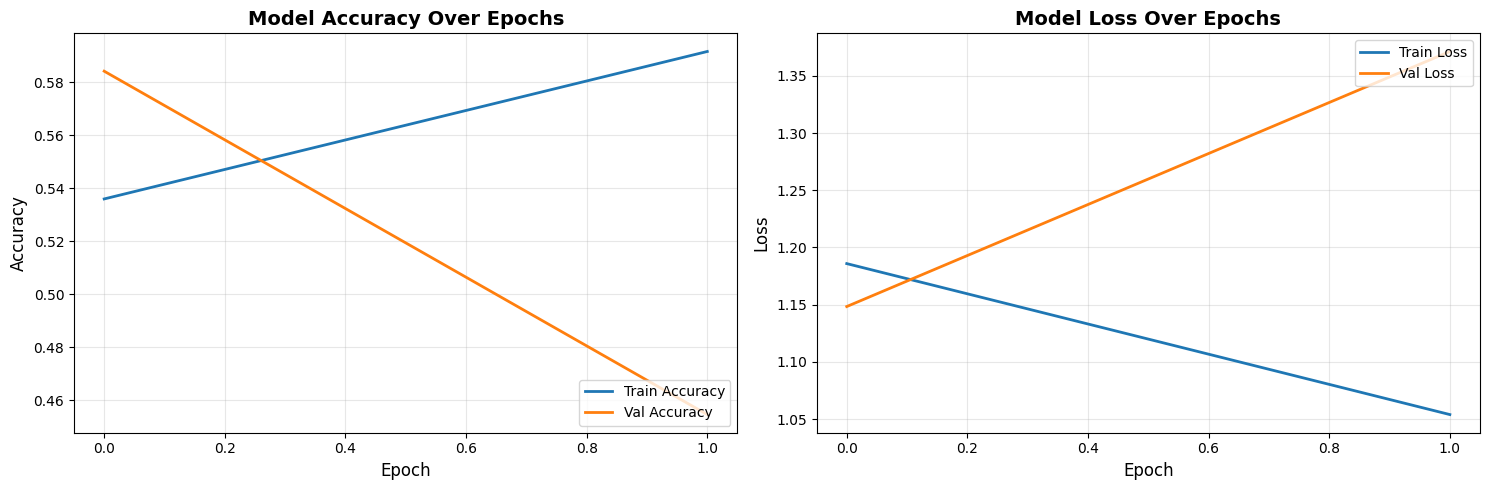

✓ Training history saved to: /Users/ashishrathore/FarmAI-Assistant/results/metrics/training_history.json

✓ Deep learning model training complete. Best model saved and history recorded.


In [11]:

# 3. DEEP LEARNING MODEL TRAINING


print("\n======================================================================")
print("PHASE 2: DEEP LEARNING MODEL TRAINING")
print("======================================================================")

try:
    model, history = train_model_pipeline(train_generator, val_generator, num_classes)
    
    # Save training history and plot
    plot_training_history(history, save_path=config.TRAINING_CURVES_FIGURE)
    save_training_history(history, save_path=config.TRAINING_HISTORY_PATH)
    
    print("\n✓ Deep learning model training complete. Best model saved and history recorded.")

except Exception as e:
    print(f" An unexpected error occurred during deep learning model training: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1) # Exit if training fails




PHASE 3: DEEP LEARNING MODEL EVALUATION


✓ Model loaded from: /Users/ashishrathore/FarmAI-Assistant/models/crop_disease_classifier_final.h5

EVALUATING MODEL PERFORMANCE

Generating predictions on test set...
174/174 [==============================] - 9s 40ms/step

OVERALL TEST ACCURACY: 59.28%

DETAILED CLASSIFICATION REPORT:
                             precision    recall  f1-score     support
Pepper__bell Bacterial_spot   0.578947  0.660000  0.616822  150.000000
Pepper__bell healthy          0.909091  0.270270  0.416667  222.000000
Potato Early_blight           0.534091  0.940000  0.681159  150.000000
Potato Late_blight            0.580311  0.746667  0.653061  150.000000
Potato healthy                0.000000  0.000000  0.000000   23.000000
accuracy                      0.592806  0.592806  0.592806    0.592806
macro avg                     0.520488  0.523387  0.473542  695.000000
weighted avg                  0.655857  0.592806  0.554182  695.000000
✓ Classification report saved to: /Users/ashishrathore/FarmAI-Assistant/r

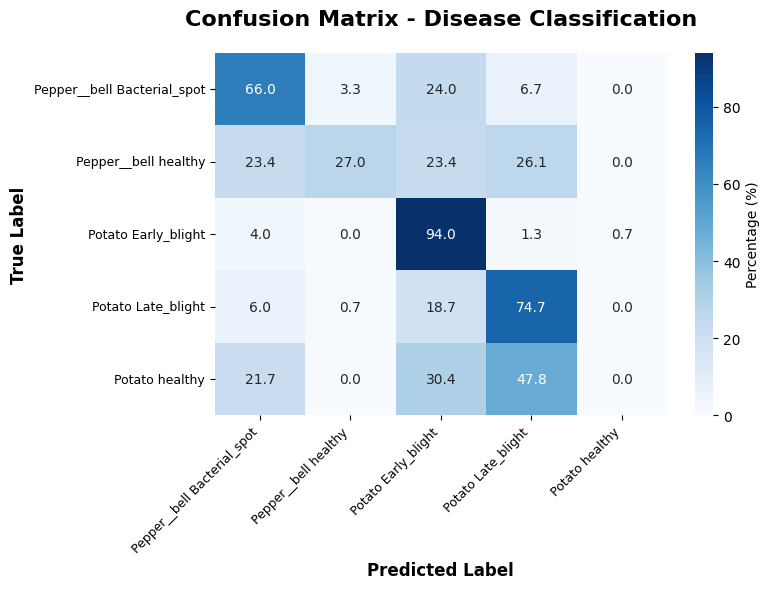


----------------------------------------------------------------------
VISUALIZING SAMPLE PREDICTIONS
----------------------------------------------------------------------
✓ Sample predictions plot saved to: /Users/ashishrathore/FarmAI-Assistant/results/figures/sample_predictions.png


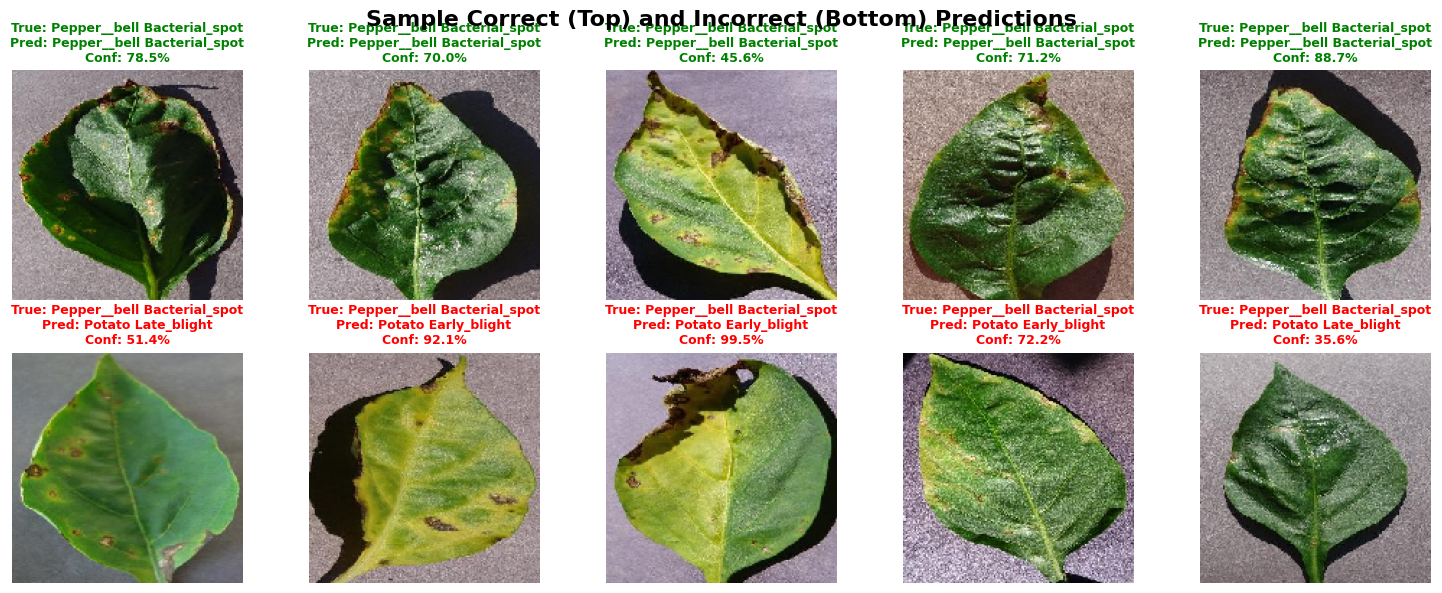


 Grad-CAM failed (optional): name 'visualize_gradcam_for_samples_fixed' is not defined
   Continuing without Grad-CAM visualization...

✓ Deep learning model evaluation complete!

EVALUATION COMPLETE


In [12]:
# 4. DEEP LEARNING MODEL EVALUATION


print("\n======================================================================")
print("PHASE 3: DEEP LEARNING MODEL EVALUATION")
print("======================================================================")

try:
    # Load model
    if not config.FINAL_MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found: {config.FINAL_MODEL_PATH}")
    
    model = tf.keras.models.load_model(config.FINAL_MODEL_PATH)
    print(f"✓ Model loaded from: {config.FINAL_MODEL_PATH}")
    
    # Load class indices
    loaded_class_indices = load_class_indices() 
    loaded_class_names = list(loaded_class_indices.keys())
    
    # Ensure consistency
    test_generator.class_indices = loaded_class_indices
    
    # Evaluate
    accuracy, predicted_classes, true_labels, report_df = evaluate_model_performance(
        model, test_generator, loaded_class_names
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(true_labels, predicted_classes, loaded_class_names, 
                         save_path=config.CONFUSION_MATRIX_FIGURE)
    
    # Visualize predictions
    visualize_sample_predictions(model, test_generator, loaded_class_names, 
                                num_correct=5, num_incorrect=5, 
                                save_path=config.PREDICTIONS_FIGURE)
    
    #  FIX: Use fixed Grad-CAM function
    try:
        visualize_gradcam_for_samples_fixed(
            model, test_generator, loaded_class_names, 
            num_samples=config.GRADCAM_NUM_SAMPLES, 
            save_path=config.GRADCAM_FIGURE
        )
    except Exception as e:
        print(f"\n Grad-CAM failed (optional): {e}")
        print(f"   Continuing without Grad-CAM visualization...")
    
    print("\n✓ Deep learning model evaluation complete!")
    
    # Update manager report
    manager_report_path = project_root / "deliverables" / "manager_report.txt"
    if manager_report_path.exists():
        with open(manager_report_path, 'r') as f:
            report_content = f.read()
        
        updated_report_content = report_content.replace(
            "[INSERT ACTUAL ACCURACY HERE, e.g., 95.2%]", 
            f"{accuracy*100:.2f}%"
        )
        
        with open(manager_report_path, 'w') as f:
            f.write(updated_report_content)
        
        print(f"✓ Manager report updated: {manager_report_path}")

except Exception as e:
    print(f" Evaluation error: {e}")
    import traceback
    traceback.print_exc()
    
    #  FIX: Don't exit - print summary instead
    print(f"\n Some evaluation steps failed, but core metrics were generated")
    print(f"   Check the results folder for available outputs")

print(f"\n" + "="*80)
print(f"EVALUATION COMPLETE")
print(f"="*80)


In [13]:
# ============================================================================
# 5. PIPELINE COMPLETION
# ============================================================================

print("\n======================================================================")
print("END-TO-END DEEP LEARNING PIPELINE COMPLETE")
print("======================================================================")
print("""
The deep learning-based crop disease classification pipeline has successfully
completed all stages: data preparation, model training, and comprehensive evaluation.
All artifacts (trained model, metrics, figures) are saved to their respective directories.

To run the Gradio demo, execute:
python demo/app_gradio.py
""")


END-TO-END DEEP LEARNING PIPELINE COMPLETE

The deep learning-based crop disease classification pipeline has successfully
completed all stages: data preparation, model training, and comprehensive evaluation.
All artifacts (trained model, metrics, figures) are saved to their respective directories.

To run the Gradio demo, execute:
python demo/app_gradio.py

